In [1]:
import os
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot
import IPython
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from adabound import AdaBound
import numpy as np
import copy

In [3]:
generator = torch.hub.load('ndahlquist/pytorch-hub-stylegan:0.0.1', 'style_gan', pretrained=True)

Using cache found in /home/andrewg/.cache/torch/hub/ndahlquist_pytorch-hub-stylegan_0.0.1


In [4]:
generator = generator.cpu()

vgg = models.vgg16(pretrained=True)
vgg = nn.Sequential(*[list(vgg.children())[0][i] for i in range(16)])
vgg.cpu()

# Freeze both networks
for child in vgg.children():
    for param in child.parameters():
        param.requires_grad = False

for child in generator.children():
    for param in child.parameters():
        param.requires_grad = False

full_model = nn.Sequential(generator, vgg)

After training the resnet, we can now make good initial estimates of what latent vector should be provided to get a desired image. 

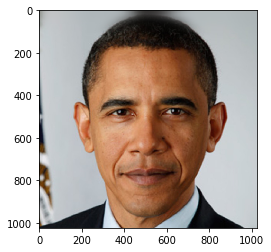

In [6]:
query_image = Image.open("aligned_images/obama.png").resize((1024, 1024))
query_image = torch.from_numpy(np.array(query_image)).float()

query_image = query_image.permute(2, 0, 1)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1/0.229, 1/0.224, 1/0.225])

query_image = query_image.unsqueeze(0)
pyplot.imshow(query_image.squeeze(0).permute(1, 2, 0).byte().detach().cpu().numpy())
IPython.display.clear_output(True)
pyplot.show()

In [10]:
try:
    w_vector = torch.load("estimate.pt")
except:
    w_vector = torch.randn(1, 512)

print("w_vector size is {}".format(w_vector.shape))

w_vector size is torch.Size([1, 512])


In [11]:
def display_image(img):
    # img = img.clamp_(-1, 1).add_(1).div_(2.0)
    pyplot.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    IPython.display.clear_output(True)
    pyplot.show()

In [12]:
def get_input_optimizer(latent):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([latent.requires_grad_()], lr=0.001, weight_decay=0.)
    return optimizer

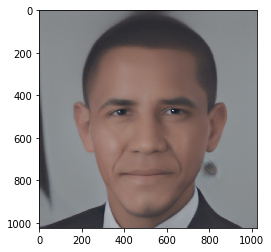

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

1.5271937847137451


In [13]:
def encoding_optimizer(gen_vgg, in_vector, query_image, num_epochs, pretrain=False):
  
    children = list(gen_vgg.children())
    gen = children[0].g_synthesis.cuda()

    loss_function = nn.MSELoss().cuda()
    in_vector = torch.tensor(in_vector)
    optimizer = get_input_optimizer(in_vector)
    
    if not pretrain:
        for idx in tqdm(range(num_epochs)):
            gen.zero_grad()
            w_vector = torch.cat(18*[in_vector]).unsqueeze(0)
            output = gen(w_vector)
            
            output = (output - output.min()) / (output.max() - output.min())
            output = output * 255
            loss = loss_function(output, query_image.cuda()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if idx % 300 == 0:
                display_image(output.byte())
            elif idx % 100 == 0:
                print(loss.item())
            
    else:
        vgg = children[1].cuda()
        query_image = (query_image - query_image.min()) / (query_image.max() - query_image.min())
        query_image[0] = normalize(query_image[0])
        vgg_latent_code_for_query_image = vgg(query_image.cuda())
        for idx in tqdm(range(num_epochs)):
            gen_vgg.zero_grad()
            w_vector = torch.cat(18*[in_vector]).unsqueeze(0)
            output = gen(w_vector)
            output = (output - output.min()) / (output.max() - output.min())
            if idx % 300 == 0:
                output_img = output.clone() * 255
                display_image(output_img.byte())
            output[0] = normalize(output[0])
            output_vec = vgg(output)
            loss = loss_function(output_vec, vgg_latent_code_for_query_image) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if idx % 100 == 0:
                print(loss.item())
    return in_vector

w_vector = encoding_optimizer(full_model, w_vector, query_image, num_epochs=200, pretrain=True)

In [14]:
age_vector = np.load('pggan_celebahq_age_boundary.npy')
age_vector = torch.from_numpy(age_vector).float()
age_vector = generator.g_mapping(age_vector).cuda()
scalar = 0.015

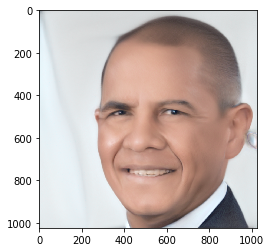

In [16]:
%matplotlib inline
images = []
with torch.no_grad():
    for idx in range(100):
        scaled_vector = w_vector + idx * scalar * age_vector
        scaled = torch.cat(18*[scaled_vector]).unsqueeze(0)
        img = generator.g_synthesis(scaled_vector)
        img = img.clamp_(-1, 1).add_(1).div_(2.0)        
        img = img.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()
        if idx % 20 == 0:
            images.append(img)
        pyplot.imshow(img)
        IPython.display.clear_output(True)
        pyplot.show()